<a href="https://colab.research.google.com/github/gspandhana/MachineLearning/blob/main/P4_MultipleRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with categorical variables
**Creating a Design Matrix**

Dataset from https://www.statlearning.com/resources-python


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
# Load the credit data.
df = pd.read_csv('credit.csv')
df.head()


,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


In [ ]:
# The response variable will be 'Balance.'
x = df.drop('Balance', axis=1)
y = df['Balance']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Trying to fit on all features in their current representation throws an error.
try:
  test_model = LinearRegression().fit(x_train, y_train)
except Exception as e:
  print('Error!:', e)

Error!: could not convert string to float: 'Yes'


In [ ]:
df.dtypes

Income       float64
Limit          int64
Rating         int64
Cards          int64
Age            int64
Education      int64
Own           object
Student       object
Married       object
Region        object
Balance        int64
dtype: object

In [ ]:
# Fit a linear model using only the numeric features in the dataframe.
numeric_features = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education']
model1 = LinearRegression().fit(x_train[numeric_features], y_train)

# Report train and test R2 scores.
train_score = model1.score(x_train[numeric_features], y_train)
test_score = model1.score(x_test[numeric_features], y_test)
print('Train R2:', train_score)
print('Test R2:', test_score)

Train R2: 0.8884475002185803
Test R2: 0.8212531865399557


In [ ]:
# Look at unique values of Ethnicity feature.
print('In the train data, Region takes on the values:', list(x_train['Region'].unique()))

In the train data, Region takes on the values: ['West', 'South', 'East']


We need two variables (n-1) to encode the 'Region' feature.

In [ ]:
# Create x train and test design matrices creating dummy variables for the categorical.
# We can use pd.get_dummies() with the drop_first hyperparameter for this
x_train_design = pd.get_dummies(x_train, drop_first = True)
x_test_design = pd.get_dummies(x_test, drop_first = True)
x_train_design.head()

,Income,Limit,Rating,Cards,Age,Education,Own_Yes,Student_Yes,Married_Yes,Region_South,Region_West
3,148.924,9504,681,3,36,11,1,0,0,0,1
18,49.570,6384,448,1,28,9,1,0,1,0,1
202,21.038,1448,145,2,58,13,1,0,1,1,0
250,10.363,2430,191,2,47,18,1,0,1,0,1
274,30.550,5869,439,5,81,9,1,0,0,0,0


In [ ]:
x_train_design.dtypes

Income          float64
Limit             int64
Rating            int64
Cards             int64
Age               int64
Education         int64
Own_Yes           uint8
Student_Yes       uint8
Married_Yes       uint8
Region_South      uint8
Region_West       uint8
dtype: object

In [ ]:
# Fit model2 on design matrix
model2 = LinearRegression().fit(x_train_design, y_train)

# Report train and test R2 scores
train_score = model2.score(x_train_design, y_train)
test_score = model2.score(x_test_design, y_test)
print('Train R2:', train_score)
print('Test R2:', test_score)

Train R2: 0.9552255011405162
Test R2: 0.9522674050276461


In [ ]:
# Note that the intercept is not a part of .coef_ but is instead stored in .intercept_.
coefs = pd.DataFrame(model2.coef_, index=x_train_design.columns, columns=['beta_value'])
coefs

,beta_value
Income,-7.554059
Limit,0.198058
Rating,0.971292
Cards,19.123826
Age,-0.603695
Education,-1.078674
Own_Yes,-12.493725
Student_Yes,418.435398
Married_Yes,-6.150365
Region_South,11.517153


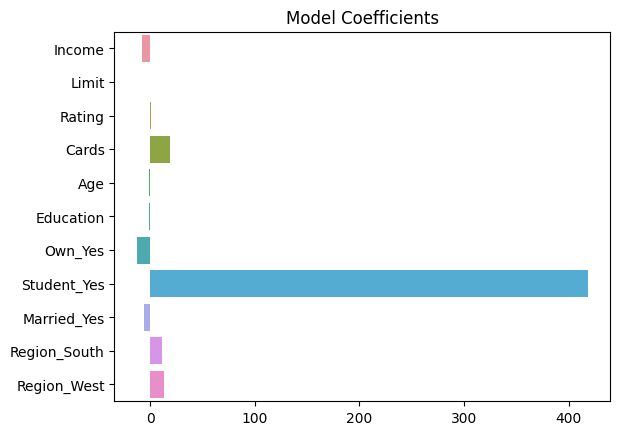

In [ ]:
# Visualize crude measure of feature importance.
sns.barplot(data=coefs.T, orient='h').set(title='Model Coefficients');

In this case, the feature 'Student_Yes' has the strongest relationship with Balance.

Let's fit a model to predict Balance from 2 predictors: Income and the best categorical feature - 'Student_Yes'.

In [ ]:
best_cat_feature = 'Student_Yes'

# Define the model.
features = ['Income', best_cat_feature]
model3 = LinearRegression()
model3.fit(x_train_design[features], y_train)

# Collect betas from fitted model.
beta0 = model3.intercept_
beta1 = model3.coef_[features.index('Income')]
beta2 = model3.coef_[features.index(best_cat_feature)]

# Display betas in a DataFrame.
coefs = pd.DataFrame([beta0, beta1, beta2], index=['Intercept']+features, columns=['beta_value'])
coefs

,beta_value
Intercept,177.658909
Income,6.773090
Student_Yes,371.895694


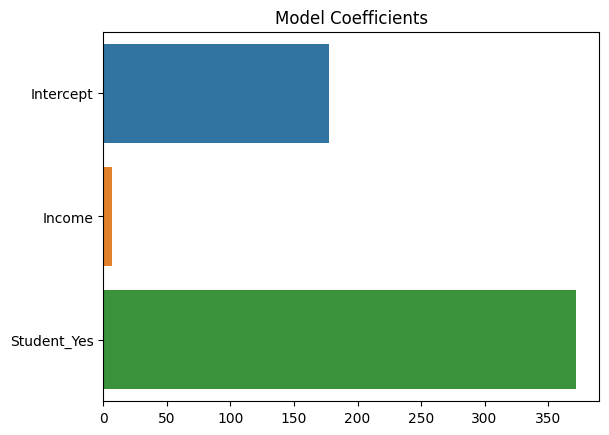

In [ ]:
# Visualize crude measure of feature importance.
sns.barplot(data=coefs.T, orient='h').set(title='Model Coefficients');

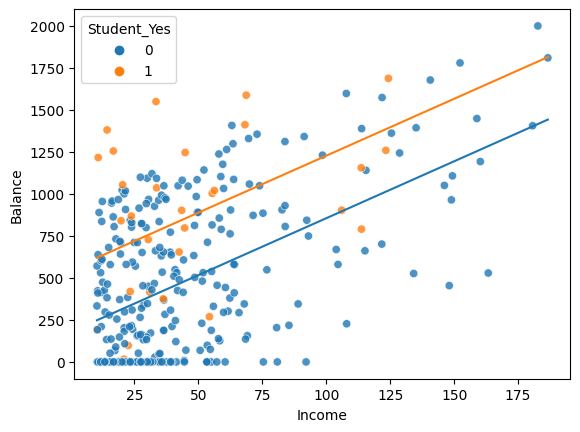

In [ ]:
# Create space of x values to predict on.
x_space = np.linspace(x['Income'].min(), x['Income'].max(), 1000)

# Generate 2 sets of predictions based on best categorical feature value.
# When categorical feature is true/present (1)
y_hat_yes = beta0 + beta1 * x_space + beta2 * 1
# When categorical feature is false/absent (0)
y_hat_no = beta0 + beta1 * x_space + beta2 * 0

# Plot the 2 prediction lines for students and non-students.
ax = sns.scatterplot(data=pd.concat([x_train_design, y_train], axis=1), x='Income', y='Balance', hue=best_cat_feature, alpha=0.8)
ax.plot(x_space, y_hat_no)
ax.plot(x_space, y_hat_yes);

The effect of student staus on credit card balance is that "Student_Yes = 1" averages higher balances.

## Importance of feature scaling
Feature scaling keeps all the regression coefficients in the same order of magnitude. This makes interpretation a bit easier.

### Why does scaling affect the fit of regression model?
Polynomial or interaction terms introduce collinearity into the design matrix. Moreover, higher order predictors raise very small or very large number to large powers and may cause a numerical overflow. Sometimes, raising a predictor to power may result in an ill-conditioned matrix that cannot be inverted. Feature scaling prevents these issues.


### Types of scaling
1.   Min-Max scaling: Normalizes (data is scaled between 0-1)
2.   Standard scalar: Standardizes (data is centred around the origin and the spread is defined by standard deviation)


